# **Part 3: Neural Network**

### Imports

In [21]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import warnings

### Processing Dataset

For this task, you will need to consider three different scenarios so you will need to process data three times.
- Predict the movement of the robot for the next 3 seconds i.e., 90 datapoints (x, y) at once based on previous:

    * 3 seconds i.e., 90 previous datapoints.
    * 6 seconds i.e., 180 previous datapoints.
    * 9 seconds i.e., 270 previous datapoints.

In [22]:
warnings.filterwarnings("ignore", category=UserWarning, message="To copy construct from a tensor*")


def process_data(file_name):
    with open(file_name, 'r') as file:
        data = [list(map(int, line.strip().split(','))) for line in file]
    return np.array(data)

def split_data(input_data, lookback):
    chunks = [input_data[i:i + lookback] for i in range(0, len(input_data), lookback)]
    X = np.array(chunks[:-1])
    Y = np.array(chunks[1:])

    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)


train_data_path = 'Dataset/Training/training_data.txt'
test_data_path = 'Dataset/Testing/test01.txt'

train_data = process_data(train_data_path)
test_data = process_data(test_data_path)

lookback = 90

X_train, y_train = split_data(train_data, lookback)
X_test, y_test = split_data(test_data, lookback)

# print("X_train shape", X_train.shape)
# print("y_train shape", y_train.shape)


 ### Model Architecture//Lookback = 90

Epoch [1000/28000], Loss: 2779.0417
Epoch [2000/28000], Loss: 1551.4076
Epoch [3000/28000], Loss: 903.1841
Epoch [4000/28000], Loss: 567.9421
Epoch [5000/28000], Loss: 955.2441
Epoch [6000/28000], Loss: 277.8108
Epoch [7000/28000], Loss: 244.8575
Epoch [8000/28000], Loss: 281.3844
Epoch [9000/28000], Loss: 209.4164
Epoch [10000/28000], Loss: 167.4072
Epoch [11000/28000], Loss: 2246.2361
Epoch [12000/28000], Loss: 135.8410
Epoch [13000/28000], Loss: 65.6283
Epoch [14000/28000], Loss: 883.0176
Epoch [15000/28000], Loss: 68.2797
Epoch [16000/28000], Loss: 116.3074
Epoch [17000/28000], Loss: 47.7242
Epoch [18000/28000], Loss: 31.3433
Epoch [19000/28000], Loss: 151.3630
Epoch [20000/28000], Loss: 23.2450
Epoch [21000/28000], Loss: 99.9285
Epoch [22000/28000], Loss: 30.4540
Epoch [23000/28000], Loss: 647.5599
Epoch [24000/28000], Loss: 31.9685
Epoch [25000/28000], Loss: 88.1900
Epoch [26000/28000], Loss: 21.1813
Epoch [27000/28000], Loss: 17.6328
Epoch [28000/28000], Loss: 23.5849
---


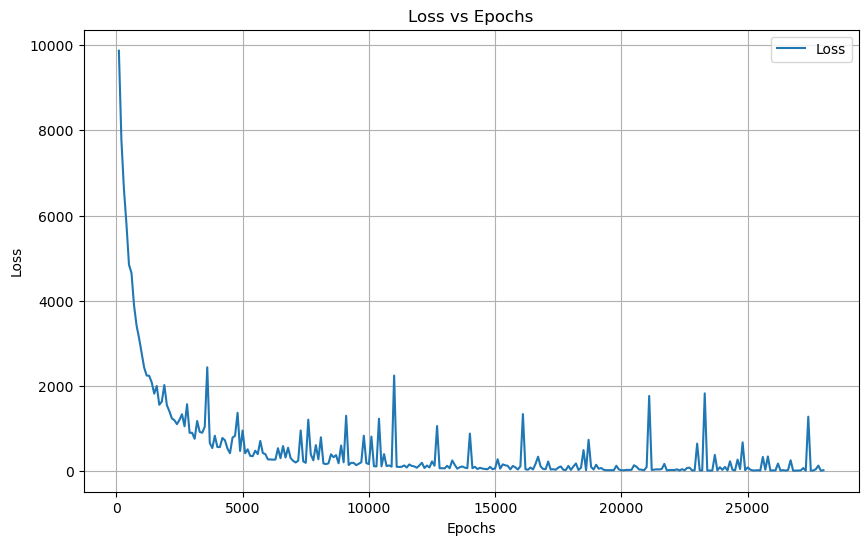

RMSE: 266.35977


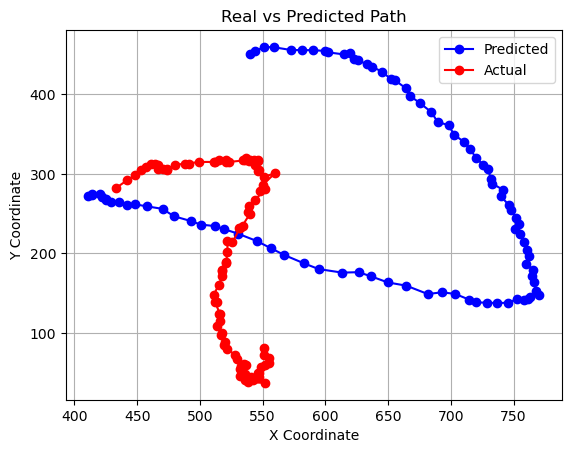

In [23]:
class NeuralNet(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNet, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_shape, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, output_shape)
        )

    def forward(self, x):
        return self.model(x)

def train_model(model, X_train, y_train, input_shape, output_shape, num_epochs=28000, learning_rate=0.001):
    loss_function = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    loss_history = []

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        outputs = model(X_train.view(-1, input_shape))
        loss = loss_function(outputs, y_train.view(-1, output_shape))

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 1000 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

        if (epoch + 1) % 100 == 0:
            loss_history.append(loss.item())

    return loss_history, num_epochs

input_shape = lookback * 2
output_shape = 90 * 2

model = NeuralNet(input_shape, output_shape)

# print(X_train.view(-1, input_shape).shape)
# print(y_train.view(-1, output_shape).shape)

loss_90, num_epochs = train_model(model, X_train, y_train, input_shape, output_shape)
print("---")
plt.figure(figsize=(10, 6))
plt.plot(range(100, num_epochs + 1, 100), loss_90, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()


def predict(input_data, model):
    input_converted = torch.tensor(input_data, dtype=torch.float32)

    with torch.no_grad():
        model.eval()
        output_converted = model(input_converted.view(1, -1)).reshape(90, 2)
        output = output_converted.numpy()

    return output

def calculate_rmse(x_test, y_test, model):
    all_rmse = []

    for i in range(len(x_test)):
        curr_chunk = x_test[i]
        curr_chunk_actual = y_test[i].numpy()
        predicted_chunk = predict(curr_chunk, model)

        squared_diff_x = (predicted_chunk[:, 0] - curr_chunk_actual[:, 0]) ** 2
        squared_diff_y = (predicted_chunk[:, 1] - curr_chunk_actual[:, 1]) ** 2

        mean_squared_diff_x = np.mean(squared_diff_x)
        mean_squared_diff_y = np.mean(squared_diff_y)

        rmse_x = np.sqrt(mean_squared_diff_x)
        rmse_y = np.sqrt(mean_squared_diff_y)

        total_rmse = rmse_x + rmse_y
        all_rmse.append(total_rmse)

    mean_rmse = np.mean(all_rmse)
    return mean_rmse

def plot_graphs(predictions, real_path):
    x_pred, y_pred = predictions[:, 0], predictions[:, 1]
    x_real, y_real = real_path[:, 0], real_path[:, 1]

    plt.plot(x_pred, y_pred, marker='o', linestyle='-', color='blue', label='Predicted')
    plt.plot(x_real, y_real, marker='o', linestyle='-', color='red', label='Actual')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Real vs Predicted Path')
    plt.legend()
    plt.grid(True)
    plt.show()

input_shape = lookback * 2
output_shape = 90 * 2       

rmse_90 = calculate_rmse(X_test, y_test, model)
print("RMSE:", rmse_90)

time_range = 9
test_selected = X_test[time_range]
predictions = predict(test_selected, model)
real_path = y_test[time_range].numpy()

plot_graphs(predictions, real_path)


 ### Model Architecture//Lookback = 180

Epoch [1000/20000], Loss: 417.9718
Epoch [2000/20000], Loss: 146.7916
Epoch [3000/20000], Loss: 53.6786
Epoch [4000/20000], Loss: 31.6441
Epoch [5000/20000], Loss: 52.7173
Epoch [6000/20000], Loss: 1664.8054
Epoch [7000/20000], Loss: 10.8686
Epoch [8000/20000], Loss: 9.4582
Epoch [9000/20000], Loss: 8.9884
Epoch [10000/20000], Loss: 41.9464
Epoch [11000/20000], Loss: 5.2454
Epoch [12000/20000], Loss: 5.8594
Epoch [13000/20000], Loss: 9.3446
Epoch [14000/20000], Loss: 115.0127
Epoch [15000/20000], Loss: 194.9763
Epoch [16000/20000], Loss: 2.8440
Epoch [17000/20000], Loss: 2.8754
Epoch [18000/20000], Loss: 9.5873
Epoch [19000/20000], Loss: 6.9448
Epoch [20000/20000], Loss: 6.7418
---


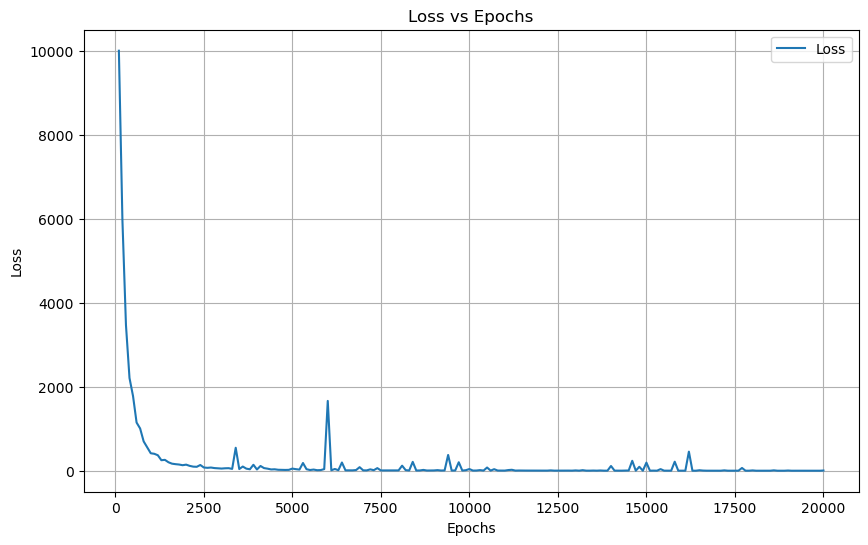

RMSE: 272.90921371437383


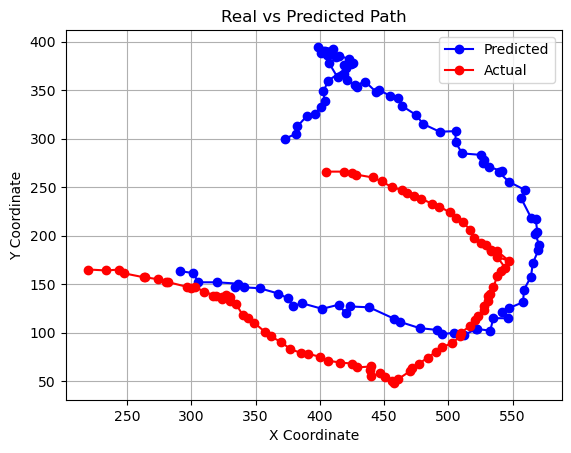

In [24]:
class NeuralNet180(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNet180, self).__init__()
        self.fc1 = nn.Linear(input_shape, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, output_shape)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def lookbacks(my_data, lookback):
    return [my_data[i:i + lookback] for i in range(0, len(my_data), lookback)]

def prep_train(my_data, lookback):
    lookback_list = lookbacks(my_data, lookback)
    X_train = np.array(lookback_list[:-1])
    y_train = np.array([chunk[:90] for chunk in lookback_list[1:]])
    return torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)

def prep_test(my_data, lookback):
    lookback_list = lookbacks(my_data, lookback)
    X_test = np.array(lookback_list[:-1])
    y_test = np.array([chunk[:90] for chunk in lookback_list[1:]])
    return X_test, y_test

lookback = 180
X_train, y_train = prep_train(train_data, lookback)
X_test, y_test = prep_test(test_data, lookback)

# print("x_train shape", X_train.shape)
# print("y_train shape", y_train.shape)
# print("x_test shape", X_test.shape)
# print("y_test shape", y_test.shape)

input_shape = lookback * 2
output_shape = 90 * 2
model180 = NeuralNet180(input_shape, output_shape)
loss_calc180 = nn.MSELoss()
optimizer = optim.Adam(model180.parameters(), lr=0.001)

# print(X_train.view(-1, input_shape).shape)
# print(y_train.view(-1, output_shape).shape)

num_epochs = 20000
loss_180 = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model180(X_train.view(-1, input_shape))
    loss = loss_calc180(outputs, y_train.view(-1, output_shape))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    if (epoch + 1) % 100 == 0:
        loss_180.append(loss.item())
print("---")
plt.figure(figsize=(10, 6))
plt.plot(range(100, num_epochs + 1, 100), loss_180, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Prediction function
def predict(input_data, model):
    input_converted = torch.tensor(input_data, dtype=torch.float32)
    with torch.no_grad():
        model.eval()
        output_converted = model(input_converted.view(1, -1)).reshape(90, 2)
        output = output_converted.numpy()
    return output

def calculate_rmse(x_test, y_test, model):
    all_rmse = []
    for i in range(len(x_test)):
        curr_chunk = x_test[i]
        curr_chunk_actual = y_test[i]  # y_test is already a numpy array
        predicted_chunk = predict(curr_chunk, model)

        squared_diff_x = (predicted_chunk[:, 0] - curr_chunk_actual[:, 0]) ** 2
        squared_diff_y = (predicted_chunk[:, 1] - curr_chunk_actual[:, 1]) ** 2

        mean_squared_diff_x = np.mean(squared_diff_x)
        mean_squared_diff_y = np.mean(squared_diff_y)

        rmse_x = np.sqrt(mean_squared_diff_x)
        rmse_y = np.sqrt(mean_squared_diff_y)

        total_rmse = rmse_x + rmse_y
        all_rmse.append(total_rmse)

    mean_rmse = np.mean(all_rmse)
    return mean_rmse

rmse_180 = calculate_rmse(X_test, y_test, model180)
print("RMSE:", rmse_180)

def plot_graphs(predictions, real_path):
    x_pred, y_pred = predictions[:, 0], predictions[:, 1]
    x_real, y_real = real_path[:, 0], real_path[:, 1]

    plt.plot(x_pred, y_pred, marker='o', linestyle='-', color='blue', label='Predicted')
    plt.plot(x_real, y_real, marker='o', linestyle='-', color='red', label='Actual')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Real vs Predicted Path')
    plt.legend()
    plt.grid(True)
    plt.show()

time_range = 7
test_selected = X_test[time_range]
predictions = predict(test_selected, model180)
real_path = y_test[time_range]

plot_graphs(predictions, real_path)


 ### Model Architecture//Lookback = 270

Epoch [1000/12000], Loss: 289.8218


Epoch [2000/12000], Loss: 89.6578
Epoch [3000/12000], Loss: 43.3127
Epoch [4000/12000], Loss: 27.5267
Epoch [5000/12000], Loss: 16.7365
Epoch [6000/12000], Loss: 12.3755
Epoch [7000/12000], Loss: 10.2407
Epoch [8000/12000], Loss: 8.2807
Epoch [9000/12000], Loss: 7.0706
Epoch [10000/12000], Loss: 7.5303
Epoch [11000/12000], Loss: 40.9470
Epoch [12000/12000], Loss: 4.9836
---


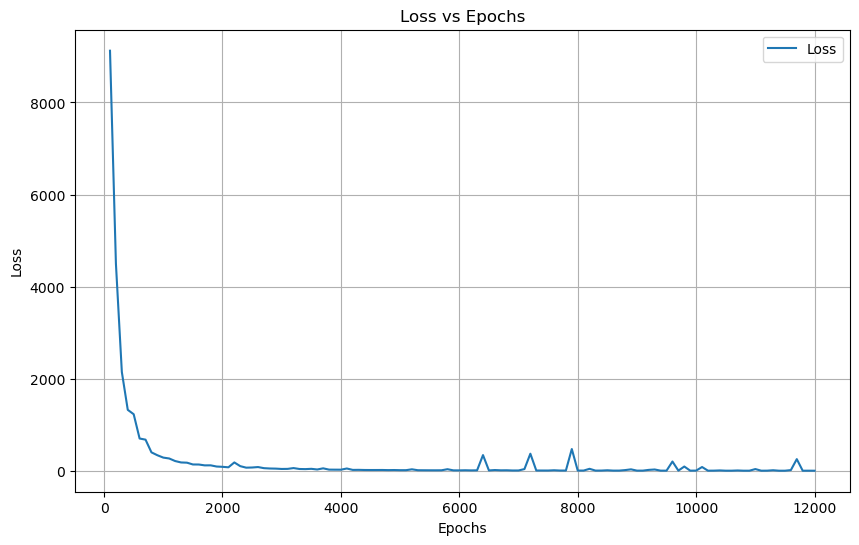

RMSE: 199.25398157405778


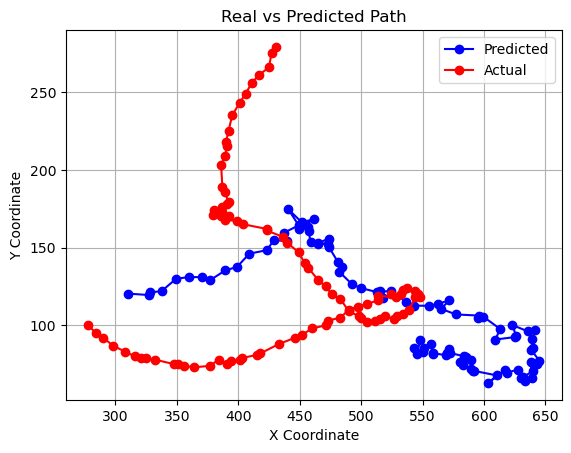

In [25]:
class NeuralNet270(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NeuralNet270, self).__init__()
        self.fc1 = nn.Linear(input_shape, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_shape)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

def lookbacks(my_data, lookback):
    return [my_data[i:i + lookback] for i in range(0, len(my_data), lookback)]

def prep_train(my_data, lookback):
    lookback_list = lookbacks(my_data, lookback)
    X_train = np.array(lookback_list[:-1])
    y_train = np.array([chunk[:90] for chunk in lookback_list[1:]])
    return torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)

def prep_test(my_data, lookback):
    lookback_list = lookbacks(my_data, lookback)
    X_test = np.array(lookback_list[:-1])
    y_test = np.array([chunk[:90] for chunk in lookback_list[1:]])
    return X_test, y_test

lookback = 270
X_train, y_train = prep_train(train_data, lookback)
X_test, y_test = prep_test(test_data, lookback)

# print("x_train shape", X_train.shape)
# print("y_train shape", y_train.shape)
# print("x_test shape", X_test.shape)
# print("y_test shape", y_test.shape)

input_shape = lookback * 2
output_shape = 90 * 2
model270 = NeuralNet270(input_shape, output_shape)
loss_calc270 = nn.MSELoss()
optimizer = optim.Adam(model270.parameters(), lr=0.001)

# print(X_train.view(-1, input_shape).shape)
# print(y_train.view(-1, output_shape).shape)

num_epochs = 12000
loss_270 = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model270(X_train.view(-1, input_shape))
    loss = loss_calc270(outputs, y_train.view(-1, output_shape))
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    if (epoch + 1) % 100 == 0:
        loss_270.append(loss.item())
print("---")
plt.figure(figsize=(10, 6))
plt.plot(range(100, num_epochs + 1, 100), loss_270, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()
plt.grid(True)
plt.show()

def predict(input_data, model):
    input_converted = torch.tensor(input_data, dtype=torch.float32)
    with torch.no_grad():
        model.eval()
        output_converted = model(input_converted.view(1, -1)).reshape(90, 2)
        output = output_converted.numpy()
    return output

def calculate_rmse(x_test, y_test, model):
    all_rmse = []
    for i in range(len(x_test)):
        curr_chunk = x_test[i]
        curr_chunk_actual = y_test[i]
        predicted_chunk = predict(curr_chunk, model)

        squared_diff_x = (predicted_chunk[:, 0] - curr_chunk_actual[:, 0]) ** 2
        squared_diff_y = (predicted_chunk[:, 1] - curr_chunk_actual[:, 1]) ** 2

        mean_squared_diff_x = np.mean(squared_diff_x)
        mean_squared_diff_y = np.mean(squared_diff_y)

        rmse_x = np.sqrt(mean_squared_diff_x)
        rmse_y = np.sqrt(mean_squared_diff_y)

        total_rmse = rmse_x + rmse_y
        all_rmse.append(total_rmse)

    mean_rmse = np.mean(all_rmse)
    return mean_rmse

rmse_270 = calculate_rmse(X_test, y_test, model270)
print("RMSE:", rmse_270)

def plot_graphs(predictions, real_path):
    x_pred, y_pred = predictions[:, 0], predictions[:, 1]
    x_real, y_real = real_path[:, 0], real_path[:, 1]

    plt.plot(x_pred, y_pred, marker='o', linestyle='-', color='blue', label='Predicted')
    plt.plot(x_real, y_real, marker='o', linestyle='-', color='red', label='Actual')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Real vs Predicted Path')
    plt.legend()
    plt.grid(True)
    plt.show()

time_range = 2
test_selected = X_test[time_range]
predictions = predict(test_selected, model270)
real_path = y_test[time_range]

plot_graphs(predictions, real_path)


### Evaluation and Analysis

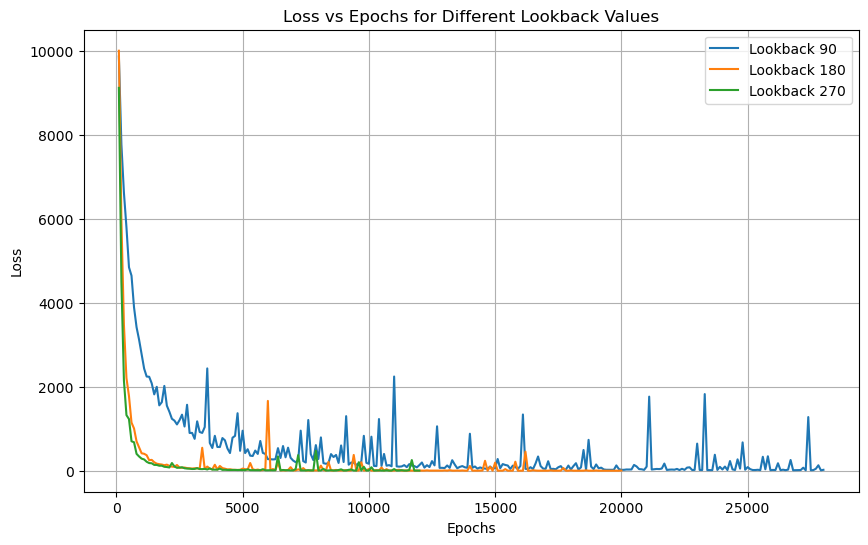

RMSE Values: [266.35977, 272.90921371437383, 199.25398157405778]


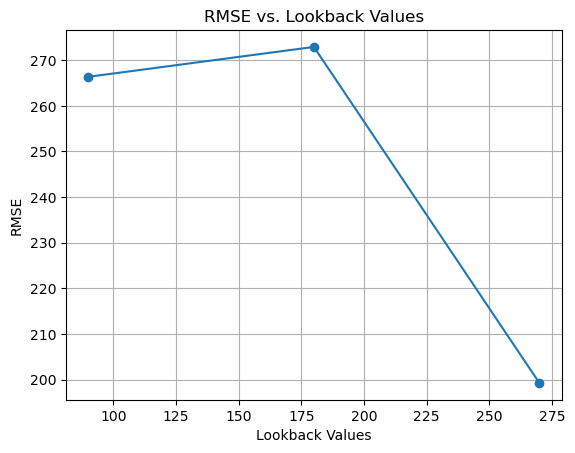

In [26]:
plt.figure(figsize=(10, 6))

# Loss vs epochs for lookback 90
plt.plot(range(100, len(loss_90) * 100 + 1, 100), loss_90, label='Lookback 90')

# Loss vs epochs for lookback 180
plt.plot(range(100, len(loss_180) * 100 + 1, 100), loss_180, label='Lookback 180')

# Loss vs epochs for lookback 270
plt.plot(range(100, len(loss_270) * 100 + 1, 100), loss_270, label='Lookback 270')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs for Different Lookback Values')
plt.legend()
plt.grid(True)
plt.show()


lookback_values = [90, 180, 270]
rmse_values = [rmse_90, rmse_180, rmse_270]

print("RMSE Values:", rmse_values)

plt.plot(lookback_values, rmse_values, marker='o')
plt.xlabel('Lookback Values')
plt.ylabel('RMSE')
plt.title('RMSE vs. Lookback Values')
plt.grid(True)
plt.show()